<a href="https://colab.research.google.com/github/mlvlab/DFC609-2022S/blob/master/HW_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Decision Tree Applications


<!-- **Goal.** <br> -->
## Goal.
The classification goal is to predict if the client will subscribe a term deposit (variable y)

<br>

## Dataset.
download dataset > > https://www.kaggle.com/janiobachmann/bank-marketing-dataset

<br>

## Ref.
- https://www.kaggle.com/shirantha/bank-marketing-data-a-decision-tree-approach/notebook
- https://www.kaggle.com/henriqueyamahata/bank-marketing
- https://www.kaggle.com/henriqueyamahata/bank-marketing/code


<br>

## Dataset Attribute Information.

### Bank client data:
- Age (numeric)
- Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
- Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
- Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
- Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')


### Related with the last contact of the current campaign:
- Contact: contact communication type (categorical:
'cellular','telephone')
- Month: last contact month of year (categorical: 'jan', 'feb', 'mar',
…, 'nov', 'dec')
- Day
- Duration: last contact duration, in seconds (numeric). Important
note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call
is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and
should be discarded if the intention is to have a realistic
predictive model.


### Other attributes:
- Campaign: number of contacts performed during this campaign and for
this client (numeric, includes last contact)
- Pdays: number of days that passed by after the client was last
contacted from a previous campaign (numeric; 999 means client was not
previously contacted)
- Previous: number of contacts performed before this campaign and for
this client (numeric)
- Poutcome: outcome of the previous marketing campaign (categorical:
'failure','nonexistent','success')


### Output variable (desired target):
- deposit - has the client subscribed a term deposit? (binary: 'yes', 'no')

# 0. Packages
- 실습을 진행하며 추가되는 코드에 따라 패키지를 추가하여 사용할 수 있습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

In [2]:
!git clone https://github.com/mlvlab/DFC609-2022S.git

fatal: destination path 'DFC609-2022S' already exists and is not an empty directory.


In [3]:
ls

DFC609-2022S/  sample_data/


# 1. Load Dataset

In [4]:
bank_df = pd.read_csv('DFC609-2022S/bank.csv')
print(bank_df.shape)
bank_df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
bank_df_enc = bank_df.copy()

# 2. Preprocessing
- 전처리 단계이며 각 변수를 이해하며 카테고리의 구성, scale 조정, 타입의 변환, 변수 제거 등 모델의 성능을 향상시키기 위한 처리를 진행할 수 있습니다.
- 아래 코드들은 기본적인 확인 과정이며, 필요한 경우 일부 변수만 사용한다거나 카테고리 변수를 더미변수로 만드는 등 해보시길 바랍니다.
- 실습 때 처럼 소수의 변수만 사용해도 좋습니다.

## 2.1. Check Null values

- Null 값이 없는 것을 확인.
- Null 값이 있다면 제거.

In [6]:
bank_df_enc[bank_df_enc.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### 2.2.1. job

In [7]:
# 변수 job의 모든 카테고리들
list(bank_df_enc.job.unique())

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

In [8]:
# 변수 job의 종류별 데이터 개수
bank_df_enc.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [9]:
# 변수 job의 종류별 y가 yes 인 데이터 개수
bank_df_enc[bank_df_enc['deposit']=='yes'].job.value_counts()

management       1301
technician        840
blue-collar       708
admin.            631
retired           516
services          369
student           269
unemployed        202
self-employed     187
entrepreneur      123
housemaid         109
unknown            34
Name: job, dtype: int64

In [10]:
# 변수 job의 카테고리가 많기 때문에 비슷한 것들끼리 묶어준다. (예시이며 원하시는대로 수정 가능합니다)
bank_df_enc['job'] = bank_df_enc['job'].replace(['management', 'admin.'], 'white-collar')
bank_df_enc['job'] = bank_df_enc['job'].replace(['services','housemaid'], 'pink-collar')
bank_df_enc['job'] = bank_df_enc['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')
# 결과확인
bank_df_enc.job.value_counts()

white-collar     3900
blue-collar      1944
technician       1823
other            1565
pink-collar      1197
self-employed     405
entrepreneur      328
Name: job, dtype: int64

In [11]:
bank_df_enc.marital.value_counts()

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

In [12]:
bank_df_enc.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [13]:
bank_df_enc.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [14]:
# other을 unknown으로 합침.
bank_df_enc['poutcome'] = bank_df_enc['poutcome'].replace(['other'] , 'unknown')
bank_df_enc.poutcome.value_counts()

unknown    8863
failure    1228
success    1071
Name: poutcome, dtype: int64

In [15]:
# 해당 변수를 사용하지 않길 원함 => 제거
bank_df_enc.drop('contact', axis=1,inplace = True)
bank_df_enc.drop('month', axis=1,inplace = True)

In [16]:
# 문자열 데이터를 숫자형으로 인코딩 한다.
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])     
        dataDF[feature] = le.transform(dataDF[feature])
    
    return dataDF

bank_df_enc = encode_features(bank_df_enc)
bank_df_enc.head()

,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,poutcome,deposit
0,59,6,1,1,0,2343,1,0,5,1042,1,-1,0,2,yes
1,56,6,1,1,0,45,0,0,5,1467,1,-1,0,2,yes
2,41,5,1,1,0,1270,1,0,5,1389,1,-1,0,2,yes
3,55,3,1,1,0,2476,1,0,5,579,1,-1,0,2,yes
4,54,6,1,2,0,184,0,0,5,673,2,-1,0,2,yes


In [17]:
bank_df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  int64 
 2   marital    11162 non-null  int64 
 3   education  11162 non-null  int64 
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   day        11162 non-null  int64 
 9   duration   11162 non-null  int64 
 10  campaign   11162 non-null  int64 
 11  pdays      11162 non-null  int64 
 12  previous   11162 non-null  int64 
 13  poutcome   11162 non-null  int64 
 14  deposit    11162 non-null  object
dtypes: int64(14), object(1)
memory usage: 1.3+ MB


# 3. Modeling

In [18]:
bank_df_enc.deposit

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
11157     no
11158     no
11159     no
11160     no
11161     no
Name: deposit, Length: 11162, dtype: object

## 3.1. set dataset

- 데이터 나누는 비율 조정 가능.



In [19]:
X = bank_df_enc.drop('deposit', axis=1)
y = bank_df_enc.deposit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14)
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test : ",X_test.shape)
print("y_test : ",y_test.shape)

X_train:  (8929, 14)
y_train:  (8929,)
X_test :  (2233, 14)
y_test :  (2233,)


In [20]:
X_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
      dtype='object')

In [21]:
y_train

2328    yes
4582    yes
3819    yes
5167    yes
9110     no
       ... 
7526     no
6471     no
2454    yes
9484     no
2667    yes
Name: deposit, Length: 8929, dtype: object

## 3.2. set model

- 이 아래부터 `decision tree` 모델과 파라미터들을 조절하여 최적의 모델을 찾아가는 과정을 작성해보세요.
- 실습 시간에 진행했던 코드들과 ref 링크들, 필요하다면 검색을 통해 쉽게 채울 수 있습니다.

In [22]:
import graphviz

In [23]:
Dtree_clf = tree.DecisionTreeClassifier(random_state=14, max_depth=5, min_samples_split= 300 )  # max_depth, min_samples_split를 수정해보세요
Dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=300, random_state=14)

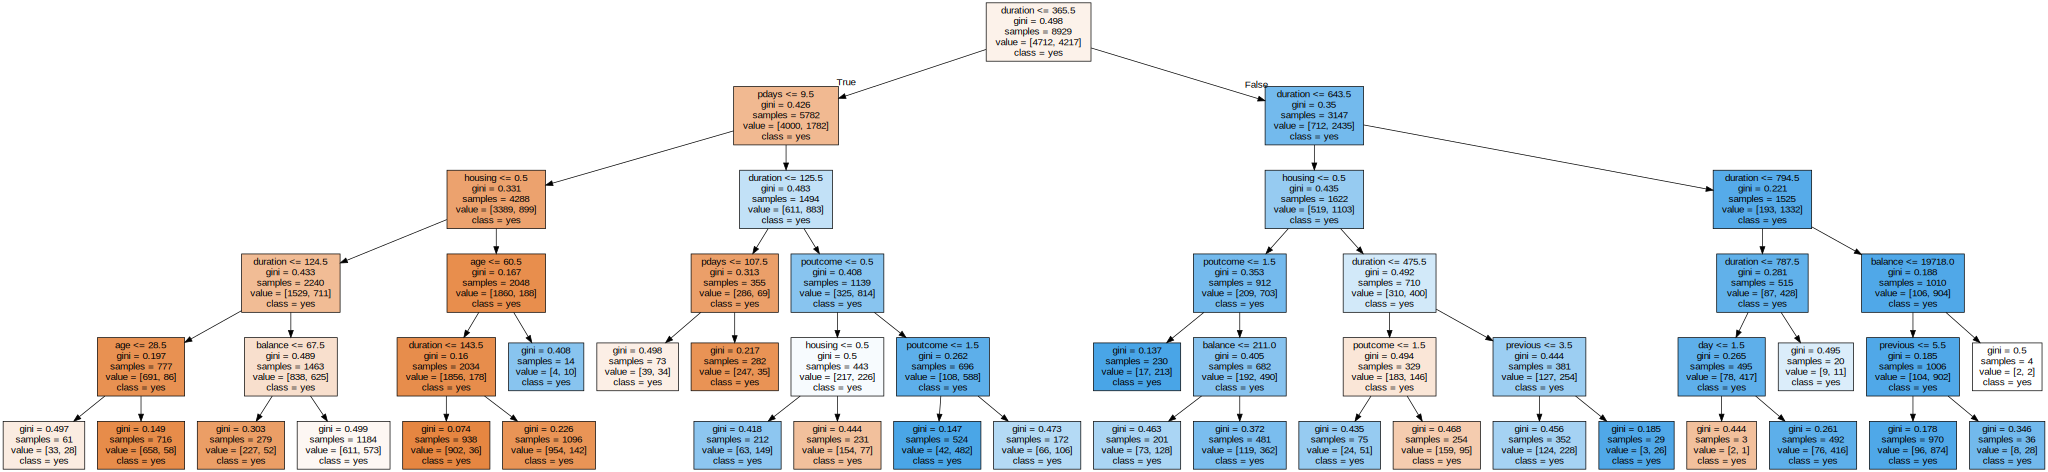

In [24]:
dot_data = export_graphviz(Dtree_clf, filled=True, out_file=None,
                           feature_names = X_train.columns,
                           class_names = y_train,
                           rounded=False)
graphviz.Source(dot_data)

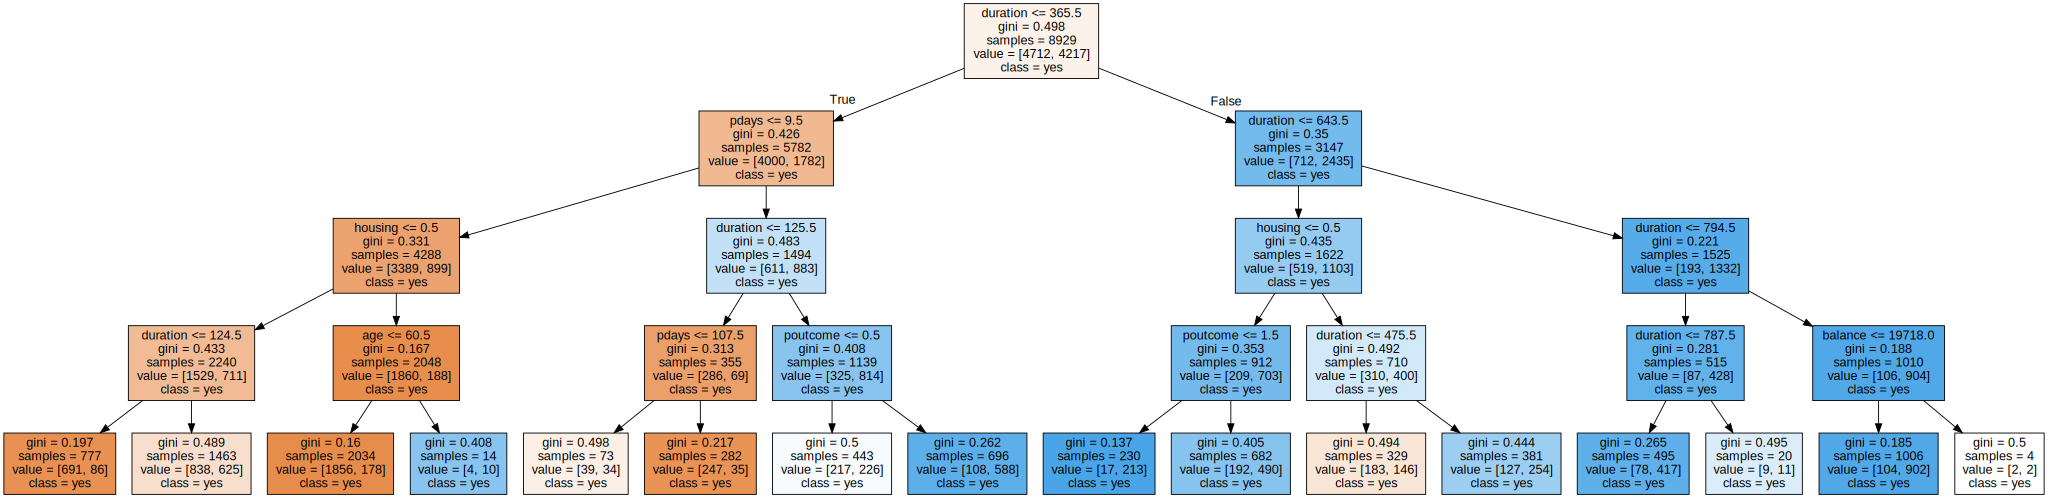

In [25]:
Dtree_clf2 = tree.DecisionTreeClassifier(random_state=14, max_depth=4, min_samples_split=20 ) # max_depth, min_samples_split를 수정해보세요
Dtree_clf2.fit(X_train, y_train)

dot_data = export_graphviz(Dtree_clf2, filled=True, out_file=None,
                           feature_names = X_train.columns,
                           class_names = y_train,
                           rounded=False)
graphviz.Source(dot_data)